In [ ]:
os.environ['NEOS_EMAIL'] = 'Your Email'

#Import

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd

import shutil
import sys
import os.path
if not shutil.which("pyomo"):
    !pip install -q pyomo
    assert(shutil.which("pyomo"))

if not (shutil.which("cbc") or os.path.isfile("cbc")):
    if "google.colab" in sys.modules:
        !apt-get install -y -qq coinor-cbc
    else:
        try:
            !conda install -c conda-forge coincbc
        except:
            pass

assert(shutil.which("cbc") or os.path.isfile("cbc"))

if not shutil.which("pyomo"):
    !pip install -q pyomo
    assert(shutil.which("pyomo"))
from pyomo.environ import *
from pyomo.gdp import *
import math
import time

#Setf5 instance

##Model

In [ ]:
data = """
1 72 0 87 4 95 2 66 3 60
4  5 3 35 0 48 2 39 1 54
1 46 3 20 2 21 0 97 4 55
0 59 3 19 4 46 1 34 2 37
4 23 2 73 3 25 1 24 0 28
3 28 0 45 4  5 1 78 2 83
0 53 3 71 1 37 4 29 2 12
4 12 2 87 3 33 1 55 0 38
2 49 3 83 1 40 0 48 4  7
2 65 3 17 0 90 4 27 1 23
"""

TASKS = {}
for job, line in enumerate(data.splitlines()[1:]):
    nums = line.split()
    prec = None
    for m, dur in zip(nums[::2], nums[1::2]):
        task = (f"J{job}",f"M{m}")
        TASKS[task] = {'dur':int(dur), 'prec':prec}
        prec = task

pd.DataFrame(TASKS).T

dur      prec
J0 M1  72.0       NaN
   M0    87  (J0, M1)
   M4    95  (J0, M0)
   M2    66  (J0, M4)
   M3    60  (J0, M2)
J1 M4   5.0       NaN
   M3    35  (J1, M4)
   M0    48  (J1, M3)
   M2    39  (J1, M0)
   M1    54  (J1, M2)
J2 M1  46.0       NaN
   M3    20  (J2, M1)
   M2    21  (J2, M3)
   M0    97  (J2, M2)
   M4    55  (J2, M0)
J3 M0  59.0       NaN
   M3    19  (J3, M0)
   M4    46  (J3, M3)
   M1    34  (J3, M4)
   M2    37  (J3, M1)
J4 M4  23.0       NaN
   M2    73  (J4, M4)
   M3    25  (J4, M2)
   M1    24  (J4, M3)
   M0    28  (J4, M1)
J5 M3  28.0       NaN
   M0    45  (J5, M3)
   M4     5  (J5, M0)
   M1    78  (J5, M4)
   M2    83  (J5, M1)
J6 M0  53.0       NaN
   M3    71  (J6, M0)
   M1    37  (J6, M3)
   M4    29  (J6, M1)
   M2    12  (J6, M4)
J7 M4  12.0       NaN
   M2    87  (J7, M4)
   M3    33  (J7, M2)
   M1    55  (J7, M3)
   M0    38  (J7, M1)
J8 M2  49.0       NaN
   M3    83  (J8, M2)
   M1    40  (J8, M3)
   M0    48  (J8, M1)
   M4     7  (J8, M0)
J9 M2  65.0       NaN
   M3    17  (J9, M2)
   M0    90  (J9, M3)
   M4    27  (J9, M0)
   M1    23  (J9, M4)

In [ ]:
def jobshop_model(TASKS, Type_Re, solver=None):

    model = ConcreteModel()

    # tasks is a two dimensional set of (j,m) constructed from the dictionary keys
    model.TASKS = Set(initialize = TASKS.keys(), dimen=2)

    # the set of jobs is constructed from a python set
    model.JOBS = Set(initialize = list(set([j for (j,m) in model.TASKS])))

    # set of machines is constructed from a python set
    model.MACHINES = Set(initialize = list(set([m for (j,m) in model.TASKS])))

    # the order of tasks is constructed as a cross-product of tasks and filtering
    model.TASKORDER = Set(initialize = model.TASKS * model.TASKS, dimen=4,
        filter = lambda model, j, m, k, n: (k,n) == TASKS[(j,m)]['prec'])

    # the set of disjunctions is cross-product of jobs, jobs, and machines
    model.DISJUNCTIONS = Set(initialize = model.JOBS * model.JOBS * model.MACHINES, dimen=3,
        filter = lambda model, j, k, m: j < k and (j,m) in model.TASKS and (k,m) in model.TASKS)

    # load duration data into a model parameter for later access
    model.dur = Param(model.TASKS, initialize=lambda model, j, m: TASKS[(j,m)]['dur'])

    # establish an upper bound on makespan
    ub = sum([model.dur[j, m] for (j,m) in model.TASKS])

    # create decision variables
    model.makespan = Var(bounds=(0, ub))
    model.start = Var(model.TASKS, bounds=(0, ub))

    model.objective = Objective(expr = model.makespan, sense = minimize)

    model.finish = Constraint(model.TASKS, rule=lambda model, j, m:
        model.start[j,m] + model.dur[j,m] <= model.makespan)

    model.preceding = Constraint(model.TASKORDER, rule=lambda model, j, m, k, n:
        model.start[k,n] + model.dur[k,n] <= model.start[j,m])

    model.disjunctions = Disjunction(model.DISJUNCTIONS, rule=lambda model,j,k,m:
        [model.start[j,m] + model.dur[j,m] <= model.start[k,m],
         model.start[k,m] + model.dur[k,m] <= model.start[j,m]])
    if solver==None:
      TransformationFactory(Type_Re).apply_to(model)
    else:
      TransformationFactory(Type_Re).apply_to(model, solver = solver)
    return model

In [ ]:
def jobshop_solve(model):
    solver_manager = SolverManagerFactory('neos')
    solver_manager.solve(model, opt='cplex')
    results = [{'Job': j,
                'Machine': m,
                'Start': model.start[j, m](),
                'Duration': model.dur[j,m],
                'Finish': model.start[(j, m)]() + model.dur[j,m]}
               for j,m in model.TASKS]
    return results

def jobshop(TASKS,Type_Re, solver):
    return jobshop_solve(jobshop_model(TASKS,Type_Re, solver))

In [ ]:
def Schedule(results):
  schedule = pd.DataFrame(results)
  print('\nSchedule by Job')
  print(schedule.sort_values(by=['Job','Start']).set_index(['Job', 'Machine']))

  print('\nSchedule by Machine')
  print(schedule.sort_values(by=['Machine','Start']).set_index(['Machine', 'Job']))

In [ ]:
def visualize(results):

    schedule = pd.DataFrame(results)
    JOBS = sorted(list(schedule['Job'].unique()))
    MACHINES = sorted(list(schedule['Machine'].unique()))
    makespan = schedule['Finish'].max()

    bar_style = {'alpha':1.0, 'lw':25, 'solid_capstyle':'butt'}
    text_style = {'color':'white', 'weight':'bold', 'ha':'center', 'va':'center'}
    colors = mpl.cm.Dark2.colors

    schedule.sort_values(by=['Job', 'Start'])
    schedule.set_index(['Job', 'Machine'], inplace=True)

    fig, ax = plt.subplots(2,1, figsize=(12, 5+(len(JOBS)+len(MACHINES))/4))

    for jdx, j in enumerate(JOBS, 1):
        for mdx, m in enumerate(MACHINES, 1):
            if (j,m) in schedule.index:
                xs = schedule.loc[(j,m), 'Start']
                xf = schedule.loc[(j,m), 'Finish']
                ax[0].plot([xs, xf], [jdx]*2, c=colors[mdx%7], **bar_style)
                ax[0].text((xs + xf)/2, jdx, m, **text_style)
                ax[1].plot([xs, xf], [mdx]*2, c=colors[jdx%7], **bar_style)
                ax[1].text((xs + xf)/2, mdx, j, **text_style)

    ax[0].set_title('Job Schedule')
    ax[0].set_ylabel('Job')
    ax[1].set_title('Machine Schedule')
    ax[1].set_ylabel('Machine')

    for idx, s in enumerate([JOBS, MACHINES]):
        ax[idx].set_ylim(0.5, len(s) + 0.5)
        ax[idx].set_yticks(range(1, 1 + len(s)))
        ax[idx].set_yticklabels(s)
        ax[idx].text(makespan, ax[idx].get_ylim()[0]-0.2, "{0:0.1f}".format(makespan), ha='center', va='top')
        ax[idx].plot([makespan]*2, ax[idx].get_ylim(), 'r--')
        ax[idx].set_xlabel('Time')
        ax[idx].grid(True)

    fig.tight_layout()

## Convex Hull

In [ ]:
start = time.time()
results = jobshop(TASKS,Type_Re='gdp.hull', solver=None)
end = time.time()
print('Execution time=',end-start)
results

Execution time= 165.79327654838562


[{'Job': 'J0', 'Machine': 'M1', 'Start': 0.0, 'Duration': 72, 'Finish': 72.0},
 {'Job': 'J0',
  'Machine': 'M0',
  'Start': 205.0,
  'Duration': 87,
  'Finish': 292.0},
 {'Job': 'J0',
  'Machine': 'M4',
  'Start': 292.0,
  'Duration': 95,
  'Finish': 387.0},
 {'Job': 'J0',
  'Machine': 'M2',
  'Start': 391.0,
  'Duration': 66,
  'Finish': 457.0},
 {'Job': 'J0',
  'Machine': 'M3',
  'Start': 533.0,
  'Duration': 60,
  'Finish': 593.0},
 {'Job': 'J1', 'Machine': 'M4', 'Start': 0.0, 'Duration': 5, 'Finish': 5.0},
 {'Job': 'J1', 'Machine': 'M3', 'Start': 28.0, 'Duration': 35, 'Finish': 63.0},
 {'Job': 'J1',
  'Machine': 'M0',
  'Start': 157.0,
  'Duration': 48,
  'Finish': 205.0},
 {'Job': 'J1',
  'Machine': 'M2',
  'Start': 352.0,
  'Duration': 39,
  'Finish': 391.0},
 {'Job': 'J1',
  'Machine': 'M1',
  'Start': 436.0,
  'Duration': 54,
  'Finish': 490.0},
 {'Job': 'J2',
  'Machine': 'M1',
  'Start': 264.0,
  'Duration': 46,
  'Finish': 310.0},
 {'Job': 'J2',
  'Machine': 'M3',
  'Start':

In [ ]:
Schedule(results)


Schedule by Job
             Start  Duration  Finish
Job Machine                         
J0  M1         0.0        72    72.0
    M0       205.0        87   292.0
    M4       292.0        95   387.0
    M2       391.0        66   457.0
    M3       533.0        60   593.0
J1  M4         0.0         5     5.0
    M3        28.0        35    63.0
    M0       157.0        48   205.0
    M2       352.0        39   391.0
    M1       436.0        54   490.0
J2  M1       264.0        46   310.0
    M3       311.0        20   331.0
    M2       331.0        21   352.0
    M0       430.0        97   527.0
    M4       538.0        55   593.0
J3  M0         0.0        59    59.0
    M3       217.0        19   236.0
    M4       236.0        46   282.0
    M1       365.0        34   399.0
    M2       457.0        37   494.0
J4  M4        17.0        23    40.0
    M2       201.0        73   274.0
    M3       286.0        25   311.0
    M1       490.0        24   514.0
    M0       565.0   

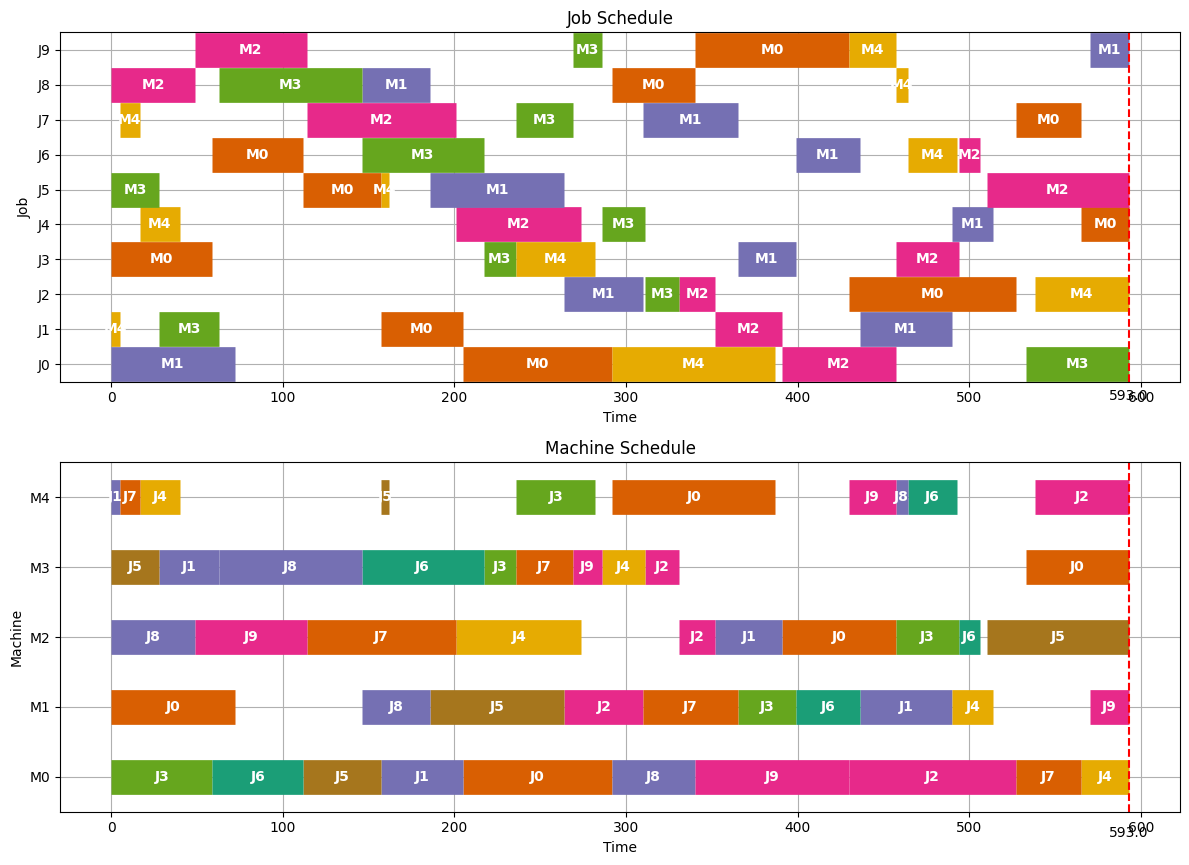

In [ ]:
visualize(results)

## Big M

In [ ]:
#start = time.time()
results = jobshop(TASKS,'gdp.bigm', solver=None)
end = time.time()
print('Execution time=',end-start)
results

  - termination condition: optimal
  - message from solver: CPLEX 22.1.1.0\x3a optimal (non-)integer solution within mipgap or absmipgap; objective 592.9996020902645; 385066 MIP simplex iterations; 29198 branch-and-bound nodes; absmipgap = 6.21736e-05, relmipgap = 1.04846e-07; 2 integer variables rounded (maxerr = 1.69902e-07).; Assigning integrality = 8e-08 might help.; Currently integrality = 1e-05.


Execution time= 8.939712285995483


[{'Job': 'J0', 'Machine': 'M1', 'Start': 0.0, 'Duration': 72, 'Finish': 72.0},
 {'Job': 'J0',
  'Machine': 'M0',
  'Start': 111.99960209026449,
  'Duration': 87,
  'Finish': 198.9996020902645},
 {'Job': 'J0',
  'Machine': 'M4',
  'Start': 198.9996020902645,
  'Duration': 95,
  'Finish': 293.9996020902645},
 {'Job': 'J0',
  'Machine': 'M2',
  'Start': 295.0,
  'Duration': 66,
  'Finish': 361.0},
 {'Job': 'J0',
  'Machine': 'M3',
  'Start': 532.9996020902645,
  'Duration': 60,
  'Finish': 592.9996020902645},
 {'Job': 'J1',
  'Machine': 'M4',
  'Start': 124.0,
  'Duration': 5,
  'Finish': 129.0},
 {'Job': 'J1',
  'Machine': 'M3',
  'Start': 270.0,
  'Duration': 35,
  'Finish': 305.0},
 {'Job': 'J1',
  'Machine': 'M0',
  'Start': 368.9996020902645,
  'Duration': 48,
  'Finish': 416.9996020902645},
 {'Job': 'J1',
  'Machine': 'M2',
  'Start': 454.9996020902645,
  'Duration': 39,
  'Finish': 493.9996020902645},
 {'Job': 'J1',
  'Machine': 'M1',
  'Start': 515.9996020902645,
  'Duration': 54,

In [ ]:
Schedule(results)


Schedule by Job
                  Start  Duration      Finish
Job Machine                                  
J0  M1         0.000000        72   72.000000
    M0       111.999602        87  198.999602
    M4       198.999602        95  293.999602
    M2       295.000000        66  361.000000
    M3       532.999602        60  592.999602
J1  M4       124.000000         5  129.000000
    M3       270.000000        35  305.000000
    M0       368.999602        48  416.999602
    M2       454.999602        39  493.999602
    M1       515.999602        54  569.999602
J2  M1        72.000000        46  118.000000
    M3       163.000000        20  183.000000
    M2       187.000000        21  208.000000
    M0       271.999602        97  368.999602
    M4       442.999602        55  497.999602
J3  M0         0.000000        59   59.000000
    M3        59.000000        19   78.000000
    M4        78.000000        46  124.000000
    M1       124.000000        34  158.000000
    M2       361.

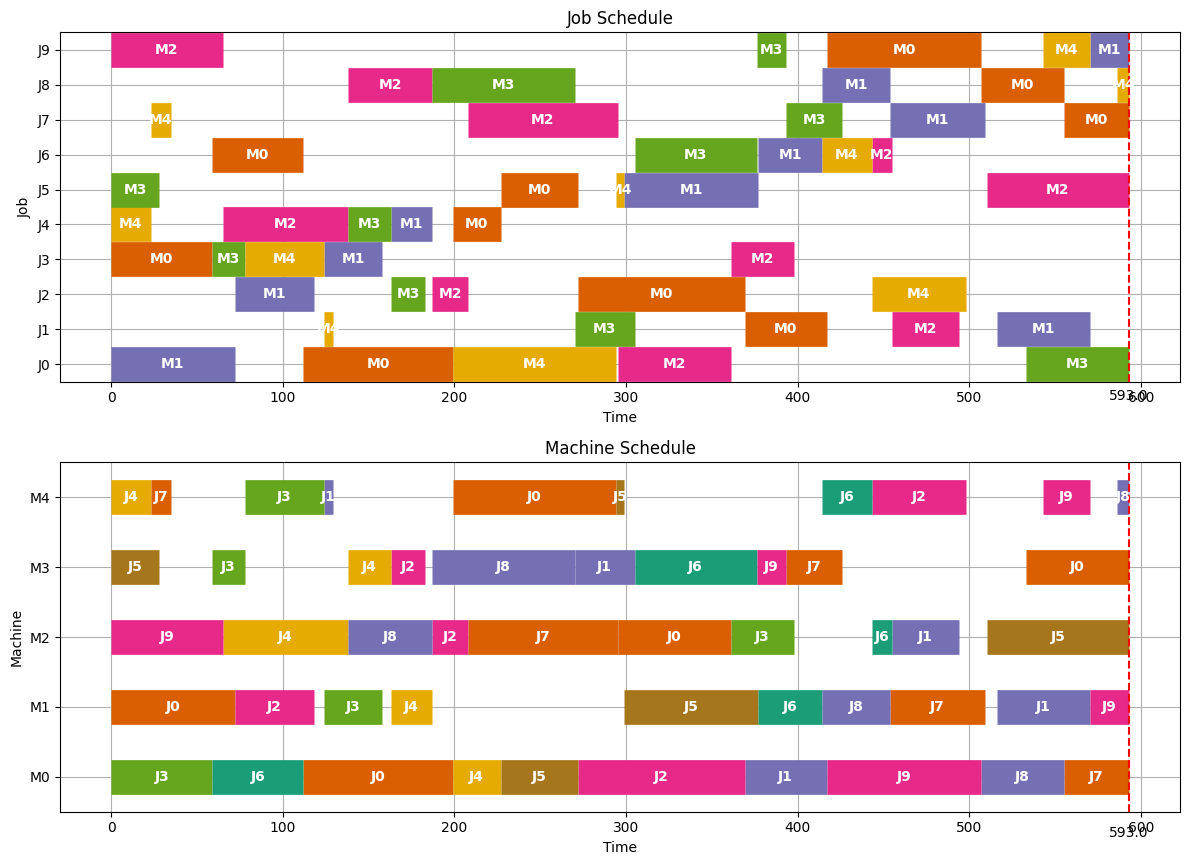

In [ ]:
visualize(results)

## Convex Hull Version 2

In [ ]:
from pyomo.environ import *
from pyomo.gdp import *

def jobshop_model(TASKS):

    model = ConcreteModel()

    # tasks is a two dimensional set of (j,m) constructed from the dictionary keys
    model.TASKS = Set(initialize = TASKS.keys(), dimen=2)

    # the set of jobs is constructed from a python set
    model.JOBS = Set(initialize = list(set([j for (j,m) in model.TASKS])))

    # set of machines is constructed from a python set
    model.MACHINES = Set(initialize = list(set([m for (j,m) in model.TASKS])))

    # the order of tasks is constructed as a cross-product of tasks and filtering
    model.TASKORDER = Set(initialize = model.TASKS * model.TASKS, dimen=4,
        filter = lambda model, j, m, k, n: (k,n) == TASKS[(j,m)]['prec'])

    # the set of disjunctions is cross-product of jobs, jobs, and machines
    model.DISJUNCTIONS = Set(initialize = model.JOBS * model.JOBS * model.MACHINES, dimen=3,
        filter = lambda model, j, k, m: j < k and (j,m) in model.TASKS and (k,m) in model.TASKS)

    # Task durations
    model.dur = Param(model.TASKS, initialize=lambda model, j, m: TASKS[(j, m)]['dur'])

    # Upper bound on makespan (sum of all task durations)
    ub = sum(model.dur[j, m] for (j, m) in model.TASKS)


    # Decision variables
    model.makespan = Var(bounds=(0, ub))
    model.start = Var(model.TASKS, bounds=(0, ub))

    model.preceding = Constraint(model.TASKORDER, rule=lambda model, j, m, k, n:
        model.start[k,n] + model.dur[k,n] <= model.start[j,m])

    # Objective: Minimize makespan
    model.objective = Objective(expr=model.makespan, sense=minimize)

    # Disjuncts for machine disjunction constraints
    def disjunct_rule(disjunct, j, k, m):
        # Disjunct 1: Task j precedes Task k
        disjunct.precede_jk = Constraint(expr=model.start[j, m] + model.dur[j, m] <= model.start[k, m])
        disjunct.finish_j = Constraint(expr=model.start[j, m] + model.dur[j, m] <= model.makespan)


    def disjunct_rule_reverse(disjunct, j, k, m):
        # Disjunct 2: Task k precedes Task j
        disjunct.precede_kj = Constraint(expr=model.start[k, m] + model.dur[k, m] <= model.start[j, m])
        disjunct.finish_k = Constraint(expr=model.start[k, m] + model.dur[k, m] <= model.makespan)

    model.disjuncts_jk = Disjunct(model.DISJUNCTIONS, rule=disjunct_rule)
    model.disjuncts_kj = Disjunct(model.DISJUNCTIONS, rule=disjunct_rule_reverse)

    # Disjunction for conflicting jobs on the same machine
    def disjunction_rule(model, j, k, m):
        return [model.disjuncts_jk[j, k, m], model.disjuncts_kj[j, k, m]]
    model.disjunctions = Disjunction(model.DISJUNCTIONS, rule=disjunction_rule)

    # Apply Hull Reformulation to transform GDP into an MILP
    TransformationFactory('gdp.hull').apply_to(model)

    return model
model = jobshop_model(TASKS)



In [ ]:
data = """
1 72 0 87 4 95 2 66 3 60
4  5 3 35 0 48 2 39 1 54
1 46 3 20 2 21 0 97 4 55
0 59 3 19 4 46 1 34 2 37
4 23 2 73 3 25 1 24 0 28
3 28 0 45 4  5 1 78 2 83
0 53 3 71 1 37 4 29 2 12
4 12 2 87 3 33 1 55 0 38
2 49 3 83 1 40 0 48 4  7
2 65 3 17 0 90 4 27 1 23
"""

TASKS = {}
for job, line in enumerate(data.splitlines()[1:]):
    nums = line.split()
    prec = None
    for m, dur in zip(nums[::2], nums[1::2]):
        task = (f"J{job}",f"M{m}")
        TASKS[task] = {'dur':int(dur), 'prec':prec}
        prec = task

pd.DataFrame(TASKS).T

dur      prec
J0 M1  72.0       NaN
   M0    87  (J0, M1)
   M4    95  (J0, M0)
   M2    66  (J0, M4)
   M3    60  (J0, M2)
J1 M4   5.0       NaN
   M3    35  (J1, M4)
   M0    48  (J1, M3)
   M2    39  (J1, M0)
   M1    54  (J1, M2)
J2 M1  46.0       NaN
   M3    20  (J2, M1)
   M2    21  (J2, M3)
   M0    97  (J2, M2)
   M4    55  (J2, M0)
J3 M0  59.0       NaN
   M3    19  (J3, M0)
   M4    46  (J3, M3)
   M1    34  (J3, M4)
   M2    37  (J3, M1)
J4 M4  23.0       NaN
   M2    73  (J4, M4)
   M3    25  (J4, M2)
   M1    24  (J4, M3)
   M0    28  (J4, M1)
J5 M3  28.0       NaN
   M0    45  (J5, M3)
   M4     5  (J5, M0)
   M1    78  (J5, M4)
   M2    83  (J5, M1)
J6 M0  53.0       NaN
   M3    71  (J6, M0)
   M1    37  (J6, M3)
   M4    29  (J6, M1)
   M2    12  (J6, M4)
J7 M4  12.0       NaN
   M2    87  (J7, M4)
   M3    33  (J7, M2)
   M1    55  (J7, M3)
   M0    38  (J7, M1)
J8 M2  49.0       NaN
   M3    83  (J8, M2)
   M1    40  (J8, M3)
   M0    48  (J8, M1)
   M4     7  (J8, M0)
J9 M2  65.0       NaN
   M3    17  (J9, M2)
   M0    90  (J9, M3)
   M4    27  (J9, M0)
   M1    23  (J9, M4)

In [ ]:
# Even after 6 hours of running still no solution!
import time

# record start time
start = time.time()
def jobshop_solve(model):
    solver_manager = SolverManagerFactory('neos')
    solver_manager.solve(model, opt='cplex')
    results = [{'Job': j,
                'Machine': m,
                'Start': model.start[j, m](),
                'Duration': model.dur[j,m],
                'Finish': model.start[(j, m)]() + model.dur[j,m]}
               for j,m in model.TASKS]
    return results

def jobshop(TASKS):
    return jobshop_solve(jobshop_model(TASKS))

results = jobshop(TASKS)

# record end time
end = time.time()
results

KeyboardInterrupt: 

In [ ]:
print(end-start)

37.19451904296875


In [ ]:
schedule = pd.DataFrame(results)

print('\nSchedule by Job')
print(schedule.sort_values(by=['Job','Start']).set_index(['Job', 'Machine']))

print('\nSchedule by Machine')
print(schedule.sort_values(by=['Machine','Start']).set_index(['Machine', 'Job']))


Schedule by Job
              Start  Duration  Finish
Job Machine                          
J0  M1          0.0        72    72.0
    M0        112.0        87   199.0
    M4        199.0        95   294.0
    M2        307.0        66   373.0
    M3       2061.0        60  2121.0
J1  M4          0.0         5     5.0
    M3          5.0        35    40.0
    M0        199.0        48   247.0
    M2        268.0        39   307.0
    M1        347.0        54   401.0
J2  M1         72.0        46   118.0
    M3        308.0        20   328.0
    M2        373.0        21   394.0
    M0       1964.0        97  2061.0
    M4       2061.0        55  2116.0
J3  M0         53.0        59   112.0
    M3        132.0        19   151.0
    M4        151.0        46   197.0
    M1        197.0        34   231.0
    M2        231.0        37   268.0
J4  M4         17.0        23    40.0
    M2         49.0        73   122.0
    M3        222.0        25   247.0
    M1        268.0        24   2

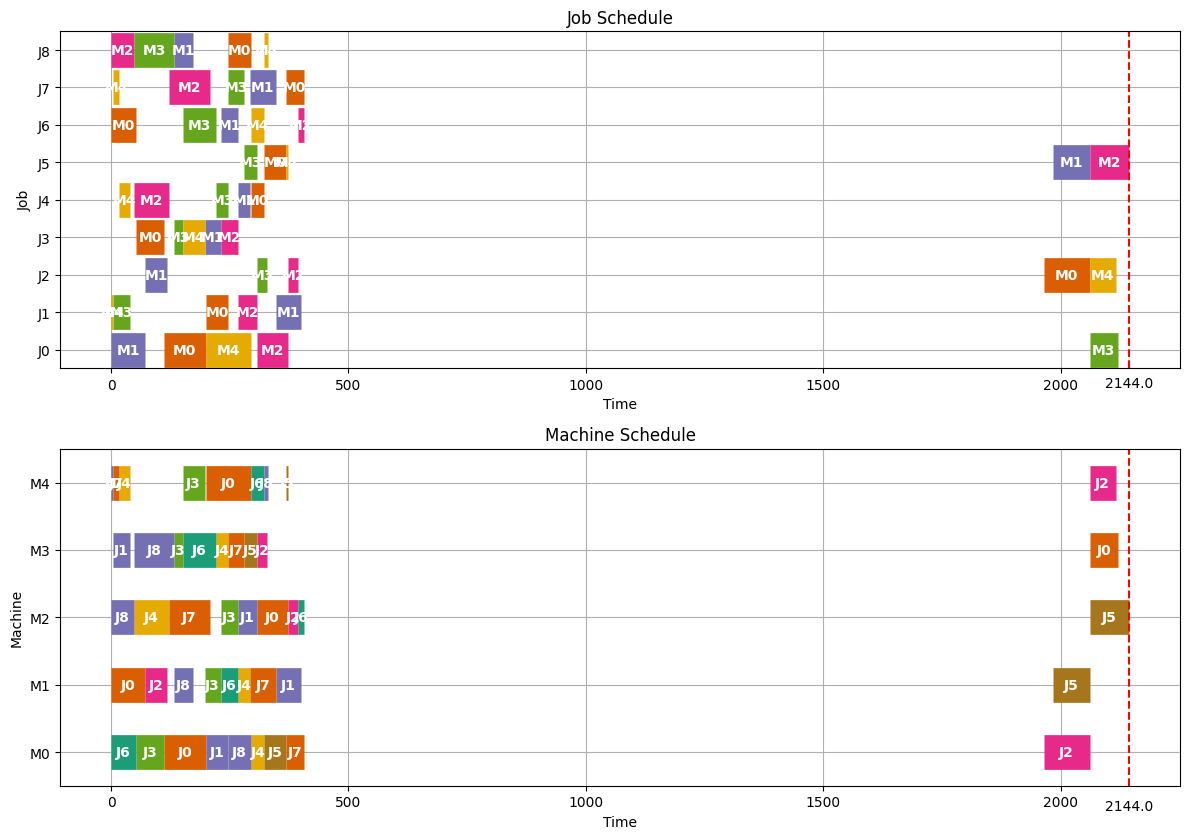

In [ ]:
def visualize(results):

    schedule = pd.DataFrame(results)
    JOBS = sorted(list(schedule['Job'].unique()))
    MACHINES = sorted(list(schedule['Machine'].unique()))
    makespan = schedule['Finish'].max()

    bar_style = {'alpha':1.0, 'lw':25, 'solid_capstyle':'butt'}
    text_style = {'color':'white', 'weight':'bold', 'ha':'center', 'va':'center'}
    colors = mpl.cm.Dark2.colors

    schedule.sort_values(by=['Job', 'Start'])
    schedule.set_index(['Job', 'Machine'], inplace=True)

    fig, ax = plt.subplots(2,1, figsize=(12, 5+(len(JOBS)+len(MACHINES))/4))

    for jdx, j in enumerate(JOBS, 1):
        for mdx, m in enumerate(MACHINES, 1):
            if (j,m) in schedule.index:
                xs = schedule.loc[(j,m), 'Start']
                xf = schedule.loc[(j,m), 'Finish']
                ax[0].plot([xs, xf], [jdx]*2, c=colors[mdx%7], **bar_style)
                ax[0].text((xs + xf)/2, jdx, m, **text_style)
                ax[1].plot([xs, xf], [mdx]*2, c=colors[jdx%7], **bar_style)
                ax[1].text((xs + xf)/2, mdx, j, **text_style)

    ax[0].set_title('Job Schedule')
    ax[0].set_ylabel('Job')
    ax[1].set_title('Machine Schedule')
    ax[1].set_ylabel('Machine')

    for idx, s in enumerate([JOBS, MACHINES]):
        ax[idx].set_ylim(0.5, len(s) + 0.5)
        ax[idx].set_yticks(range(1, 1 + len(s)))
        ax[idx].set_yticklabels(s)
        ax[idx].text(makespan, ax[idx].get_ylim()[0]-0.2, "{0:0.1f}".format(makespan), ha='center', va='top')
        ax[idx].plot([makespan]*2, ax[idx].get_ylim(), 'r--')
        ax[idx].set_xlabel('Time')
        ax[idx].grid(True)

    fig.tight_layout()

visualize(results)

## M Big M

In [ ]:
start = time.time()
results = jobshop(TASKS, 'gdp.mbigm', solver='cbc')
end = time.time()
print('Execution time for M Big M=', end-start)
results

  - termination condition: optimal
  - message from solver: CPLEX 22.1.1.0\x3a optimal (non-)integer solution within mipgap or absmipgap; objective 592.9997348098552; 1619896 MIP simplex iterations; 104681 branch-and-bound nodes; absmipgap = 1.80403e-07, relmipgap = 3.04221e-10; 3 integer variables rounded (maxerr = 1.11424e-07).; Assigning integrality = 6e-08 might help.; Currently integrality = 1e-05.


Execution time for M Big M= 37.92007923126221


[{'Job': 'J0',
  'Machine': 'M1',
  'Start': 46.0,
  'Duration': 72,
  'Finish': 118.0},
 {'Job': 'J0',
  'Machine': 'M0',
  'Start': 205.0,
  'Duration': 87,
  'Finish': 292.0},
 {'Job': 'J0',
  'Machine': 'M4',
  'Start': 331.0,
  'Duration': 95,
  'Finish': 426.0},
 {'Job': 'J0',
  'Machine': 'M2',
  'Start': 443.9997348098552,
  'Duration': 66,
  'Finish': 509.9997348098552},
 {'Job': 'J0',
  'Machine': 'M3',
  'Start': 532.9997348098552,
  'Duration': 60,
  'Finish': 592.9997348098552},
 {'Job': 'J1', 'Machine': 'M4', 'Start': 12.0, 'Duration': 5, 'Finish': 17.0},
 {'Job': 'J1', 'Machine': 'M3', 'Start': 28.0, 'Duration': 35, 'Finish': 63.0},
 {'Job': 'J1',
  'Machine': 'M0',
  'Start': 157.0,
  'Duration': 48,
  'Finish': 205.0},
 {'Job': 'J1',
  'Machine': 'M2',
  'Start': 205.0,
  'Duration': 39,
  'Finish': 244.0},
 {'Job': 'J1',
  'Machine': 'M1',
  'Start': 372.0,
  'Duration': 54,
  'Finish': 426.0},
 {'Job': 'J2', 'Machine': 'M1', 'Start': 0.0, 'Duration': 46, 'Finish': 46

In [ ]:
Schedule(results)


Schedule by Job
                  Start  Duration      Finish
Job Machine                                  
J0  M1        46.000000        72  118.000000
    M0       205.000000        87  292.000000
    M4       331.000000        95  426.000000
    M2       443.999735        66  509.999735
    M3       532.999735        60  592.999735
J1  M4        12.000000         5   17.000000
    M3        28.000000        35   63.000000
    M0       157.000000        48  205.000000
    M2       205.000000        39  244.000000
    M1       372.000000        54  426.000000
J2  M1         0.000000        46   46.000000
    M3        82.000000        20  102.000000
    M2       261.000000        21  282.000000
    M0       292.000000        97  389.000000
    M4       426.000000        55  481.000000
J3  M0         0.000000        59   59.000000
    M3       266.000000        19  285.000000
    M4       285.000000        46  331.000000
    M1       338.000000        34  372.000000
    M2       372.

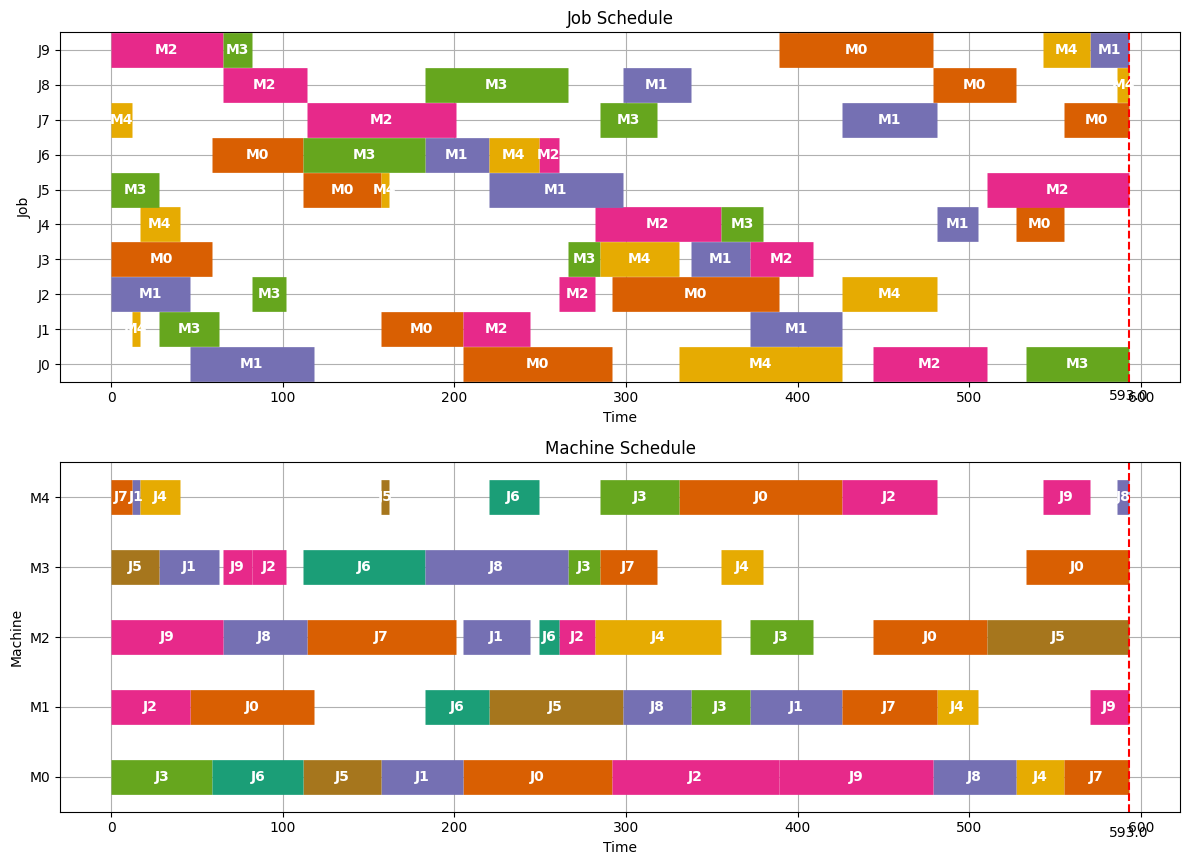

In [ ]:
visualize(results)

## Cutting Plane

In [ ]:
#27 sec
start = time.time()
results = jobshop(TASKS, Type_Re='gdp.cuttingplane', solver= None)
end = time.time()
print('Execution time for Cutting plane=', end-start)
results

ERROR:pyomo.core:Unable to clone Pyomo component attribute.
Component 'TASKS' contains an uncopyable field '_init_values' (<class 'pyomo.core.base.set.TuplizeValuesInitializer'>).  Setting field to `None` on new object
  - termination condition: optimal
  - message from solver: CPLEX 22.1.1.0\x3a optimal (non-)integer solution within mipgap or absmipgap; objective 592.9994131417934; 1288428 MIP simplex iterations; 83513 branch-and-bound nodes; absmipgap = 1.00462e-05, relmipgap = 1.69413e-08; 2 integer variables rounded (maxerr = 2.5058e-07).; Assigning integrality = 1e-07 might help.; Currently integrality = 1e-05.


Execution time for Cutting plane= 32.780189037323


[{'Job': 'J0',
  'Machine': 'M1',
  'Start': 39.99941314179341,
  'Duration': 72,
  'Finish': 111.99941314179341},
 {'Job': 'J0',
  'Machine': 'M0',
  'Start': 111.99941314179341,
  'Duration': 87,
  'Finish': 198.9994131417934},
 {'Job': 'J0',
  'Machine': 'M4',
  'Start': 252.9994131417934,
  'Duration': 95,
  'Finish': 347.9994131417934},
 {'Job': 'J0',
  'Machine': 'M2',
  'Start': 391.0,
  'Duration': 66,
  'Finish': 457.0},
 {'Job': 'J0',
  'Machine': 'M3',
  'Start': 532.9994131417934,
  'Duration': 60,
  'Finish': 592.9994131417934},
 {'Job': 'J1', 'Machine': 'M4', 'Start': 0.0, 'Duration': 5, 'Finish': 5.0},
 {'Job': 'J1', 'Machine': 'M3', 'Start': 5.0, 'Duration': 35, 'Finish': 40.0},
 {'Job': 'J1',
  'Machine': 'M0',
  'Start': 198.9994131417934,
  'Duration': 48,
  'Finish': 246.9994131417934},
 {'Job': 'J1',
  'Machine': 'M2',
  'Start': 258.0,
  'Duration': 39,
  'Finish': 297.0},
 {'Job': 'J1',
  'Machine': 'M1',
  'Start': 298.9994131417934,
  'Duration': 54,
  'Finish'

In [ ]:
Schedule(results)


Schedule by Job
                  Start  Duration      Finish
Job Machine                                  
J0  M1        39.999413        72  111.999413
    M0       111.999413        87  198.999413
    M4       252.999413        95  347.999413
    M2       391.000000        66  457.000000
    M3       532.999413        60  592.999413
J1  M4         0.000000         5    5.000000
    M3         5.000000        35   40.000000
    M0       198.999413        48  246.999413
    M2       258.000000        39  297.000000
    M1       298.999413        54  352.999413
J2  M1       215.999413        46  261.999413
    M3       277.000000        20  297.000000
    M2       297.000000        21  318.000000
    M0       339.999413        97  436.999413
    M4       436.999413        55  491.999413
J3  M0         0.000000        59   59.000000
    M3        59.000000        19   78.000000
    M4        78.000000        46  124.000000
    M1       509.999413        34  543.999413
    M2       543.

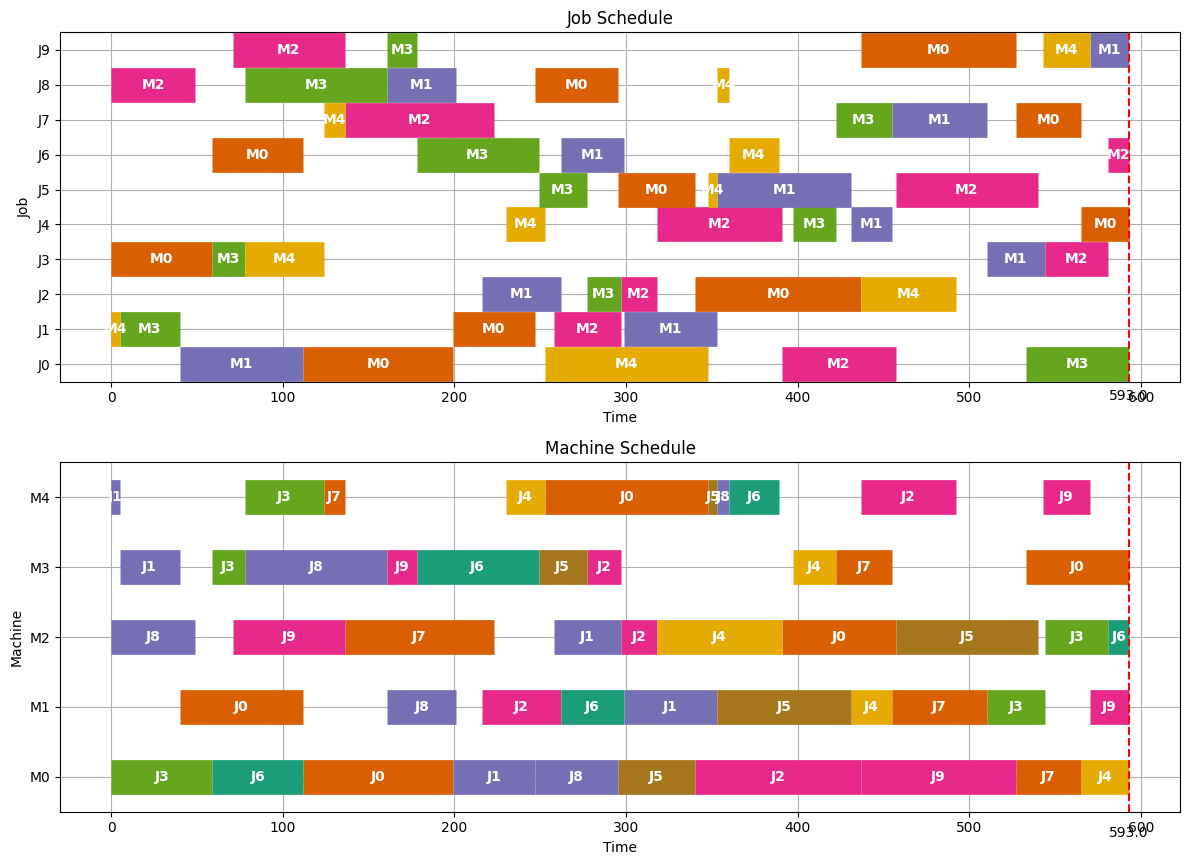

In [ ]:
visualize(results)